<h3>14.3 Pytorch实现对抗攻击</h3>

<h4>14.3.1 实现无目标攻击</h4>

In [1]:
import torch
from torch import nn
from torch.autograd.gradcheck import zero_gradients
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.models.inception import inception_v3

from PIL import Image
from scipy.misc import imsave

import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from random import randint

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes = eval(open('pytorch-14/classes.txt').read())
trans = T.Compose([T.ToTensor(), T.Lambda(lambda t: t.unsqueeze(0))])
reverse_trans = lambda x: np.asarray(T.ToPILImage()(x))


eps = 0.025
steps = 40

step_alpha = 0.01 

model = inception_v3(pretrained=True, transform_input=True).to(device)
loss = nn.CrossEntropyLoss()
model.eval();

In [3]:
def load_image(img_path):
    img = trans(Image.open(img_path).convert('RGB'))
    return img

def get_class(img):
    with torch.no_grad():
        x = img.to(device)
        cls = model(x).data.max(1)[1].cpu().numpy()[0]
        return classes[cls]

def draw_result(img, noise, adv_img):
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    orig_class, attack_class = get_class(img), get_class(adv_img)
    ax[0].imshow(reverse_trans(img[0]))
    ax[0].set_title('Original image: {}'.format(orig_class.split(',')[0]))
    ax[1].imshow(60*noise[0].detach().cpu().numpy().transpose(1, 2, 0))
    ax[1].set_title('Attacking noise')
    ax[2].imshow(reverse_trans(adv_img[0]))
    ax[2].set_title('Adversarial example: {}'.format(attack_class))
    for i in range(3):
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    fig.savefig('pytorch-14/adv01.png', dpi=fig.dpi)

In [4]:
def non_targeted_attack(img):
    img = img.to(device)
    img.requires_grad=True
    label = torch.zeros(1, 1).to(device)
    
    x, y = img, label
    for step in range(steps):  
        zero_gradients(x)
        out = model(x)
        y.data = out.data.max(1)[1]
        local_loss = loss(out, y)
        local_loss.backward()
        normed_grad = step_alpha * torch.sign(x.grad.data)
        step_adv = x.data + normed_grad
        adv = step_adv - img
        adv = torch.clamp(adv, -eps, eps)
        result = img + adv
        result = torch.clamp(result, 0.0, 1.0)
        x.data = result
     
    return result.cpu(), adv.cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


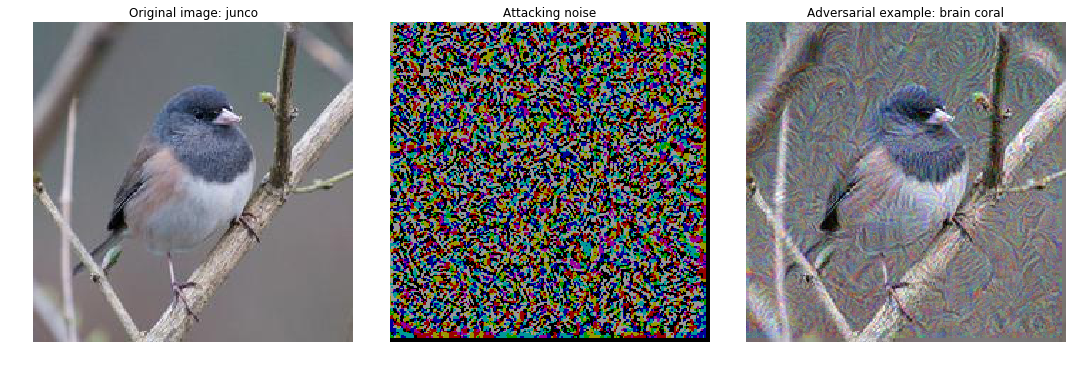

In [5]:
img = load_image('pytorch-14/bird.JPEG')
adv_img, noise = non_targeted_attack(img)
draw_result(img, noise, adv_img)

<h4>14.3.2 实现有目标攻击</h4>

In [6]:
def targeted_attack(img, label):
    
    img = img.to(device)
    img.requires_grad=True
    label = torch.Tensor([label]).long().to(device)
    
    x, y = img, label
    for step in range(steps):
        zero_gradients(x)
        out = model(x)
        local_loss = loss(out, y)
        local_loss.backward()
        normed_grad = step_alpha * torch.sign(x.grad.data)
        step_adv = x.data - normed_grad
        adv = step_adv - img
        adv = torch.clamp(adv, -eps, eps)
        result = img + adv
        result = torch.clamp(result, 0.0, 1.0)
        x.data = result
    return result.cpu(), adv.cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


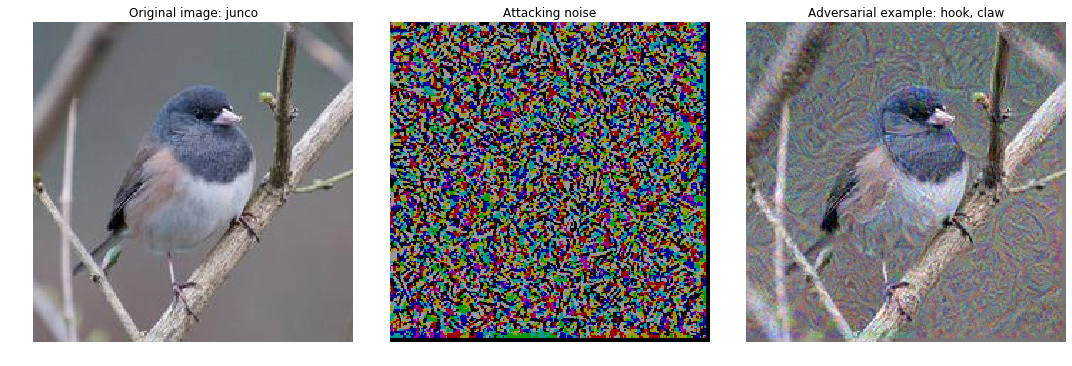

In [7]:
img = load_image('pytorch-14/bird.JPEG')
adv_img, noise = targeted_attack(img, 600)
draw_result(img, noise, adv_img)

In [8]:
def graph_result(epsilons, y1, y2, y3, title):
    fig = plt.figure()

    # xnew = np.linspace(min(epsilons), max(epsilons), 20)
    # y1_smooth = spline(epsilons, y1, xnew)
    # l1, = plt.plot(xnew, y1_smooth, 'r--', label="fast")

    l1, = plt.plot(epsilons, y1, 'r--', label="fast")
    l2, = plt.plot(epsilons, y2, 'b--', label="iter non-target")
    l3, = plt.plot(epsilons, y3, 'g--', label="iter target")

    plt.xlabel('epsilon')
    plt.ylabel('%s equivalence' % title)

    plt.legend(handles=[l1, l2, l3])
    # plt.show()

    fig.savefig('pytorch-14/'+title + '.png', dpi=fig.dpi)


In [9]:
def fgsm(img):
    img = img.to(device)
    img.requires_grad=True
    label = torch.zeros(1, 1).to(device)
    
    x, y = img, label
    zero_gradients(x)
    out = model(x)
    y.data = out.data.max(1)[1]
    local_loss = loss(out, y)
    local_loss.backward()
    # normed_grad = eps * torch.sign(x.grad.data)
    normed_grad = torch.sign(x.grad.data)
    step_adv = x.data + normed_grad
    adv = step_adv - img
    adv = torch.clamp(adv, -eps, eps)
    result = img + adv
    result = torch.clamp(result, 0.0, 1.0)

    return result.cpu(), adv.cpu()


In [10]:
def get_top_five(img):
    with torch.no_grad():
        x = img.to(device)
        top5 = model(x).data.topk(5)[1].cpu().numpy()[0]
        return [classes[cls] for cls in top5]

img: 62.jpg, eps: 0.001000, method: fgsm
img: 101.jpg, eps: 0.001000, method: fgsm
img: 61.jpg, eps: 0.001000, method: fgsm
img: 9.jpg, eps: 0.001000, method: fgsm
img: 37.jpg, eps: 0.001000, method: fgsm
img: 103.jpg, eps: 0.001000, method: fgsm
img: 83.jpg, eps: 0.001000, method: fgsm
img: 99.jpg, eps: 0.001000, method: fgsm
img: 46.jpg, eps: 0.001000, method: fgsm
img: 92.jpg, eps: 0.001000, method: fgsm
img: 59.jpg, eps: 0.001000, method: fgsm
img: 111.jpg, eps: 0.001000, method: fgsm
img: 90.jpg, eps: 0.001000, method: fgsm
img: 89.jpg, eps: 0.001000, method: fgsm
img: 39.jpg, eps: 0.001000, method: fgsm
img: 102.jpg, eps: 0.001000, method: fgsm
img: 116.jpg, eps: 0.001000, method: fgsm
img: 12.jpg, eps: 0.001000, method: fgsm
img: 43.jpg, eps: 0.001000, method: fgsm
img: 81.jpg, eps: 0.001000, method: fgsm
img: 62.jpg, eps: 0.001000, method: non_targ
img: 101.jpg, eps: 0.001000, method: non_targ
img: 61.jpg, eps: 0.001000, method: non_targ
img: 9.jpg, eps: 0.001000, method: non_t

img: 102.jpg, eps: 0.250000, method: fgsm
img: 116.jpg, eps: 0.250000, method: fgsm
img: 12.jpg, eps: 0.250000, method: fgsm
img: 43.jpg, eps: 0.250000, method: fgsm
img: 81.jpg, eps: 0.250000, method: fgsm
img: 62.jpg, eps: 0.250000, method: non_targ
img: 101.jpg, eps: 0.250000, method: non_targ
img: 61.jpg, eps: 0.250000, method: non_targ
img: 9.jpg, eps: 0.250000, method: non_targ
img: 37.jpg, eps: 0.250000, method: non_targ
img: 103.jpg, eps: 0.250000, method: non_targ
img: 83.jpg, eps: 0.250000, method: non_targ
img: 99.jpg, eps: 0.250000, method: non_targ
img: 46.jpg, eps: 0.250000, method: non_targ
img: 92.jpg, eps: 0.250000, method: non_targ
img: 59.jpg, eps: 0.250000, method: non_targ
img: 111.jpg, eps: 0.250000, method: non_targ
img: 90.jpg, eps: 0.250000, method: non_targ
img: 89.jpg, eps: 0.250000, method: non_targ
img: 39.jpg, eps: 0.250000, method: non_targ
img: 102.jpg, eps: 0.250000, method: non_targ
img: 116.jpg, eps: 0.250000, method: non_targ
img: 12.jpg, eps: 0.2500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


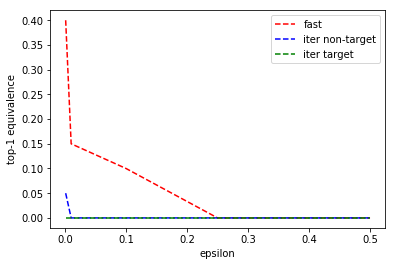

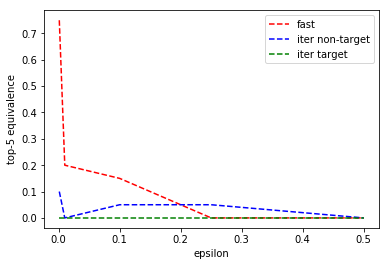

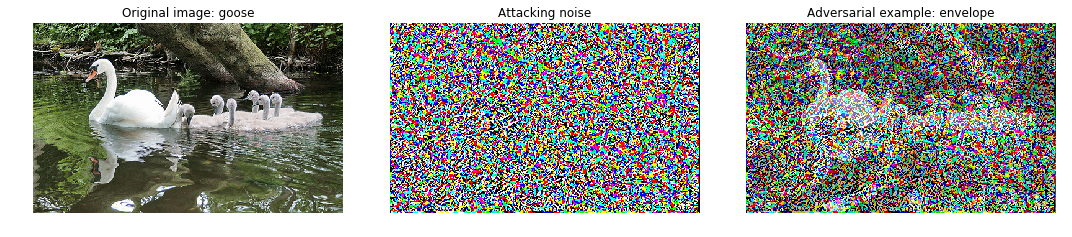

In [11]:
# load images from img dir
fnames = [f for f in os.listdir('pytorch-14/img') if '.jpg' in f]
images = []
for f in fnames:
    img = load_image('pytorch-14/img/' + f)
    images.append((f, img))

# compare different methods across eps
epsilons = [0.001, 0.01, 0.1, 0.25, 0.5]
#epsilons = [0.001]
n = 20
methods = ['fgsm', 'non_targ', 'targ']
#methods = ['non_targ']
y1_1 = []
y2_1 = []
y3_1 = []
y1_5 = []
y2_5 = []
y3_5 = []

for e in epsilons:
    eps = e

    for m in methods:
        tot1 = 0.0
        tot5 = 0.0

        for (f, img) in images[:n]:
            print('img: %s, eps: %f, method: %s' % (f, eps, m))
            target = randint(0, 999)

            # generate adversarial images for all methods
            if m == 'fgsm':
                adv_img, noise = fgsm(img)
            elif m == 'non_targ':
                adv_img, noise = non_targeted_attack(img)
            else:
                adv_img, noise = targeted_attack(img, target)

            # check if top class is equivalent
            orig_class, attack_class = get_class(img), get_class(adv_img)
            if orig_class == attack_class:
                tot1 += 1

            # check if orig class in top 5
            top5 = get_top_five(adv_img)
            if orig_class in top5:
                tot5 += 1

        tot1 /= n
        tot5 /= n

        if m == 'fgsm':
            y1_1.append(tot1)
            y1_5.append(tot5)
        elif m == 'non_targ':
            y2_1.append(tot1)
            y2_5.append(tot5)
        else:
            y3_1.append(tot1)
            y3_5.append(tot5)

# graph results of each method at each epsilon
print(y1_1, y2_1, y3_1)
graph_result(epsilons, y1_1, y2_1, y3_1, 'top-1')

print(y1_5, y2_5, y3_5)
graph_result(epsilons, y1_5, y2_5, y3_5, 'top-5')

#fgsm
img = load_image('pytorch-14/img/8.jpg')
adv_img, noise = fgsm(img)
draw_result(img, noise, adv_img)